In [1]:
# The easiest way to get recipes is to install all of tidymodels:
# install.packages("tidymodels")
install.packages("multilevelmod")
options(encoding = 'UTF-8')
#Loading all the necessary packages
if (!require("caret")) install.packages("caret")
if (!require("recipes")) install.packages("recipes")
if (!require("visreg")) install.packages("visreg")
if (!require("MASS")) install.packages("MASS")
if (!require("glmnet")) install.packages("glmnet")
if (!require("jtools")) install.packages("jtools")
if (!require("scales")) install.packages("scales")
if (!require("forcats")) install.packages("forcats")
if (!require("stringr")) install.packages("stringr")
if (!require("poissonreg")) install.packages("poissonreg")



require("caret")
require("recipes")
require("visreg")
require("MASS")
require("glmnet")
require("jtools")
require("scales")
require("forcats")
require("stringr")
require("arrow")
require("forcats")
require("doParallel")
require("yardstick")
require("parsnip")
require("workflows")
require("poissonreg")
require("rsample")
require("tune")
require("yardstick")

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150);

Installation du package dans 'C:/Users/Florian/Documents/R/win-library/4.1'
(car 'lib' n'est pas spécifié)



package 'multilevelmod' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Florian\AppData\Local\Temp\RtmpQh1clH\downloaded_packages


Le chargement a nécessité le package : caret

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice

Le chargement a nécessité le package : recipes

Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'recipes'


L'objet suivant est masqué depuis 'package:stats':

    step


Le chargement a nécessité le package : visreg

Le chargement a nécessité le package : MASS


Attachement du package : 'MASS'


L'objet suivant est masqué depuis 'package:dplyr':

    select


Le chargement a nécessité le package : glmnet

Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-3

Le chargement a nécessité le package : jtools

Le chargement a nécessité le package : scales

Le chargement a nécessité le package : forcats

Le 

In [2]:
dataset = read_parquet(file = "../data/dataset.parquet")

set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

# Lasso 

In [3]:
ptn=Sys.time()
x = model.matrix(ClaimNb ~ 0 + Power  * Region + Power*Brand + Power*Gas +  Region* Brand + Region* Gas + Brand*Gas,
                 data=training_set)
set.seed(542)
folds = createFolds(training_set$ClaimNb, 5, list=FALSE)

set.seed(58)
m.lasso.0.cv = cv.glmnet(x, y = training_set$ClaimNb, 
                         offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 1, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit=10^4,
       nlambda = 25)


ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 6.412889 mins

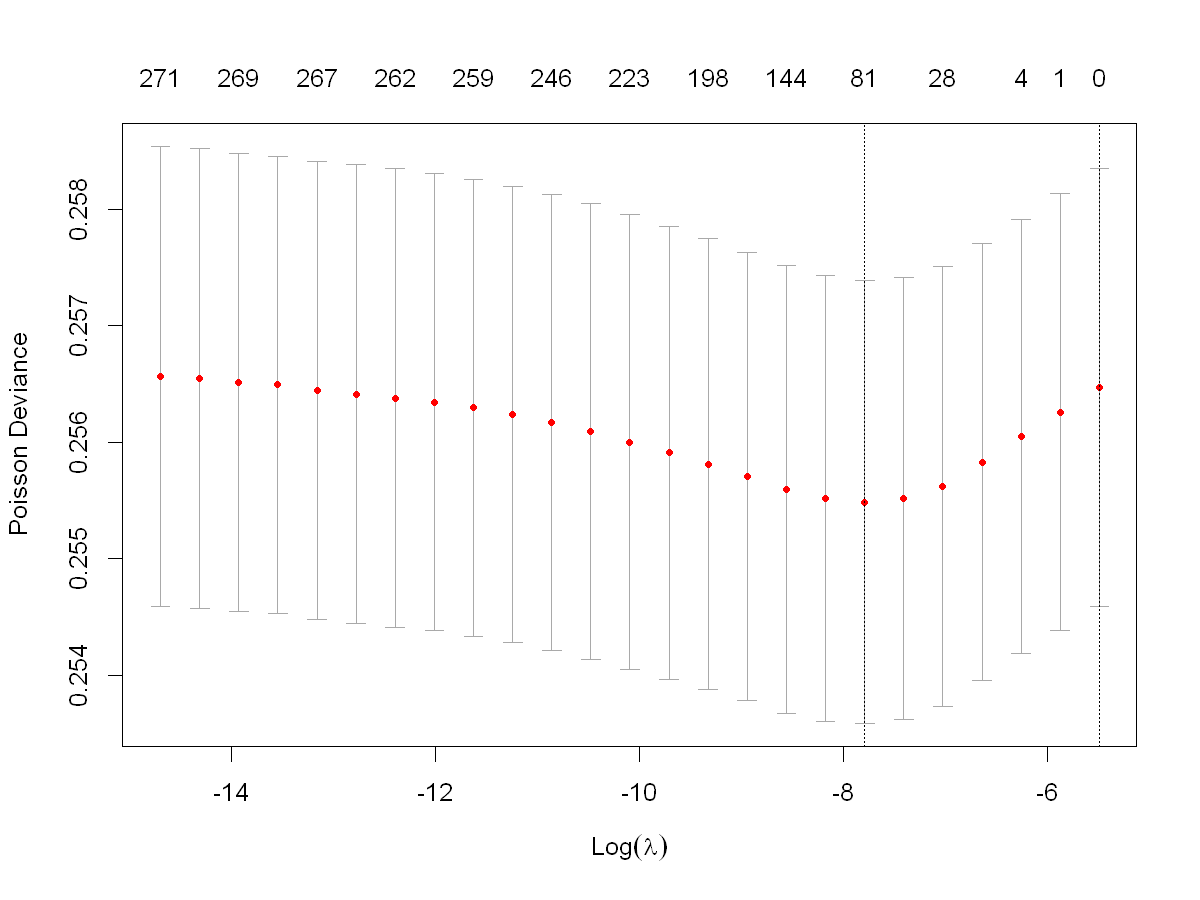

In [4]:
plot(m.lasso.0.cv)

In [5]:
coef(m.lasso.0.cv, s = "lambda.min")

274 x 1 sparse Matrix of class "dgCMatrix"
                                                                            s1
(Intercept)                                                      -2.5394767393
Powerd                                                           -0.1033242799
Powere                                                            .           
Powerf                                                            .           
Powerg                                                            .           
Powerh                                                            .           
Poweri                                                            .           
Powerj                                                            .           
Powerk                                                            .           
Powerl                                                            .           
Powerm                                                            .           
Powern   

# Ridge

In [6]:
ptn=Sys.time()
set.seed(58)
m.ridge.0.cv = cv.glmnet(x, y = training_set$ClaimNb, offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 0, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit = 10^3,
       nlambda = 25)

ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 3.835233 mins

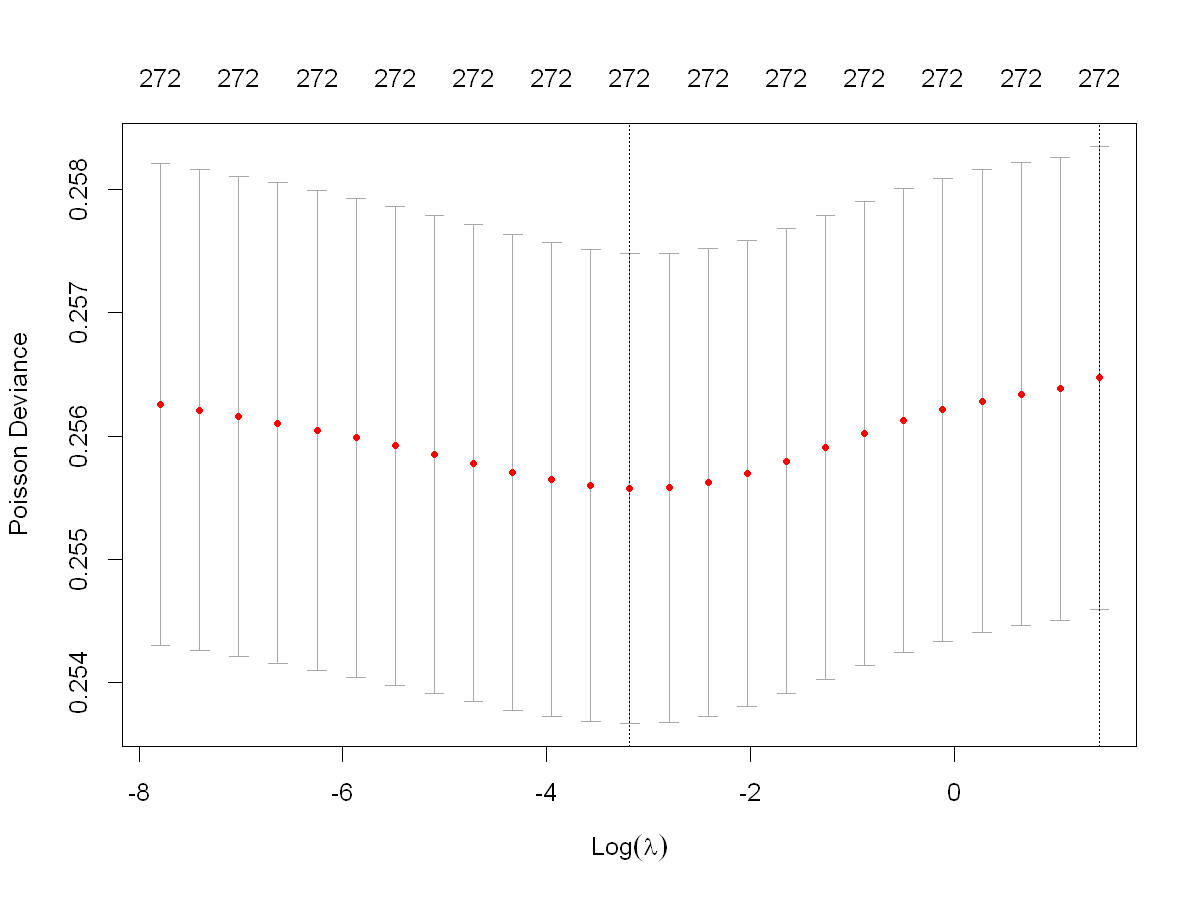

In [7]:
plot(m.ridge.0.cv)

# Elastic Net

In [8]:
ptn=Sys.time()
set.seed(58)
m.elasticnet.0.cv = cv.glmnet(x, y = training_set$ClaimNb, offset = log(training_set$Exposure),
       family = "poisson",
       alpha = 0.5, #LASSO = 1, Ridge = 0,
       nfolds = 5,
       foldid = folds,
       maxit = 10^3,
       nlambda = 25)

ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 6.278916 mins

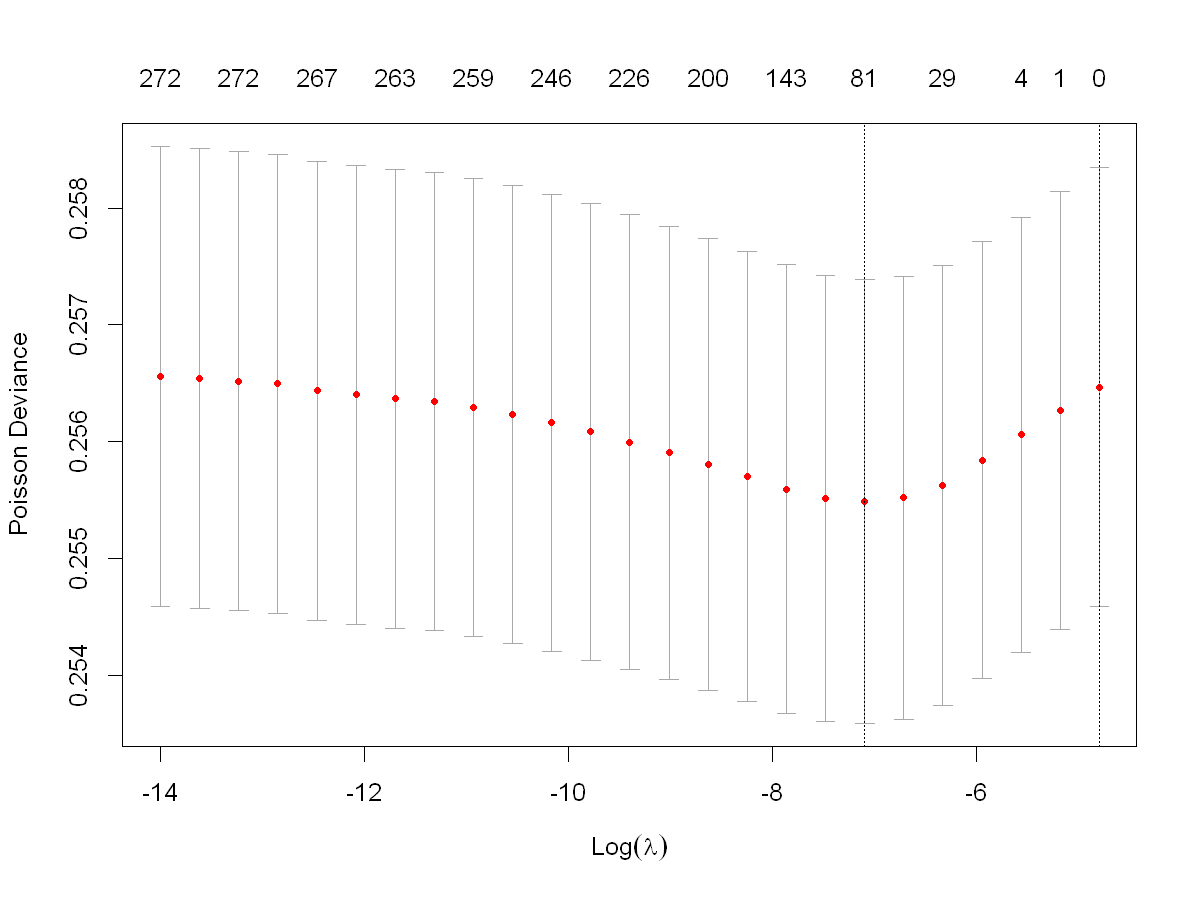

In [9]:
plot(m.elasticnet.0.cv)

# Comparison with GLM

In [10]:
x_test = model.matrix(ClaimNb ~ 0 + Power * Region + Power * Brand + Power * Gas +
    Region * Brand + Region * Gas + Brand * Gas, data = testing_set)


2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.lasso.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.lasso.0.cv$lambda.min, type = "response"),
        log = TRUE)))

[1] 20769.31

In [11]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.ridge.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.ridge.0.cv$lambda.min, type = "response"),
        log = TRUE)))

[1] 20769.93

In [12]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m.elasticnet.0.cv, newx = x_test,
        newoffset = log(testing_set$Exposure), s = m.elasticnet.0.cv$lambda.min,
        type = "response"), log = TRUE)))

[1] 20769.58

# Experiment

Let us construct the factors a bit differently. We will only use the variables DriverAge and CarAge for illustration here.

In [13]:
driver_age_lst = c()
for (age in (18:99)){
    training_set[paste0("DriverAge_", age)] = 1*(training_set$DriverAge <= age)
    testing_set[paste0("DriverAge_", age)] = 1*(testing_set$DriverAge <= age)
    driver_age_lst = c(driver_age_lst, paste0("DriverAge_", age))
}

car_age_lst = c()
for (vehage in (0:25)){
    training_set[paste0("CarAge_", vehage)] = 1*(training_set$CarAge <= vehage)
    testing_set[paste0("CarAge_", vehage)] = 1*(testing_set$CarAge <= vehage)
    car_age_lst = c(car_age_lst, paste0("CarAge_", vehage))
}

density_lst = c()
for (density in unique(quantile(training_set$Density, seq(0.01,0.99,0.01)))){
    training_set[paste0("Density_", density)] = 1*(training_set$Density <= density)
    testing_set[paste0("Density_", density)] = 1*(testing_set$Density <= density)
    density_lst = c(density_lst, paste0("Density_", density))
}

power_lst = c()
levels = levels(ordered(training_set$Power))
for (power in 1:length(unique(ordered(training_set$Power)))){
    training_set[paste0("Power_", power)] = 1*(ordered(training_set$Power) <= levels[power])
    testing_set[paste0("Power_", power)] = 1*(ordered(testing_set$Power) <= levels[power])
    power_lst = c(power_lst, paste0("Power_", power))
}

lst_vars = paste(paste(driver_age_lst, collapse=" + "), 
                 paste(car_age_lst, collapse=" + "), 
                 paste(density_lst, collapse=" + "), 
                 paste(power_lst, collapse=" + "), 
                 sep = " + ")

In [14]:
ptn=Sys.time()
model_exp_x = model.matrix(as.formula(paste("ClaimNb ~ 0  + ", 
                                            lst_vars, 
                                            sep="")),
                           data=training_set)

head(model_exp_x)

,DriverAge_18,DriverAge_19,DriverAge_20,DriverAge_21,DriverAge_22,DriverAge_23,DriverAge_24,DriverAge_25,DriverAge_26,DriverAge_27,...,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,Power_11,Power_12
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1


In [15]:
set.seed(542)
folds = createFolds(training_set$ClaimNb, 5, list=FALSE)

set.seed(58)
m.lasso.1.cv = cv.glmnet(  model_exp_x, y = training_set$ClaimNb, 
                           offset = log(training_set$Exposure),
                           family = "poisson",
                           alpha = 1, #LASSO = 1, Ridge = 0,
                           nfolds = 5,
                           foldid = folds,
                           maxit=10^4,
                           nlambda = 25)


ptn_1 = Sys.time() - ptn
ptn_1

Time difference of 7.383376 mins

In [16]:
m.lasso.1.cv


Call:  cv.glmnet(x = model_exp_x, y = training_set$ClaimNb, offset = log(training_set$Exposure),      nfolds = 5, foldid = folds, family = "poisson", alpha = 1,      maxit = 10^4, nlambda = 25) 

Measure: Poisson Deviance 

      Lambda Index Measure       SE Nonzero
min 0.000379     9  0.2523 0.001820      49
1se 0.003787     3  0.2538 0.001851      10

In [17]:
coef(m.lasso.1.cv, s = "lambda.min")

218 x 1 sparse Matrix of class "dgCMatrix"
                         s1
(Intercept)   -2.6881967110
DriverAge_18   0.1230383584
DriverAge_19   0.2425459500
DriverAge_20   0.3468576743
DriverAge_21   0.0081852836
DriverAge_22   0.1919444916
DriverAge_23   0.1115035954
DriverAge_24   0.1334220842
DriverAge_25   .           
DriverAge_26   0.2385793758
DriverAge_27   .           
DriverAge_28   0.0063266606
DriverAge_29   0.0884926007
DriverAge_30   .           
DriverAge_31   0.0330756231
DriverAge_32   .           
DriverAge_33   .           
DriverAge_34   .           
DriverAge_35   .           
DriverAge_36   .           
DriverAge_37   .           
DriverAge_38   .           
DriverAge_39   .           
DriverAge_40   .           
DriverAge_41  -0.0139173282
DriverAge_42  -0.0452490010
DriverAge_43  -0.0048463049
DriverAge_44   .           
DriverAge_45   .           
DriverAge_46   .           
DriverAge_47   .           
DriverAge_48   .           
DriverAge_49   .           
Drive

In [18]:
plotdata = expand.grid(DriverAge = 18:99, 
                       CarAge = 0:25, 
                       Density = unique(quantile(training_set$Density, seq(0.01,0.99,0.01))),
                       Exposure = 1)


for (age in (18:99)){
    plotdata[paste0("DriverAge_", age)] = 1*(plotdata$DriverAge <= age)
}
for (vehage in (0:25)){
    plotdata[paste0("CarAge_", vehage)] = 1*(plotdata$CarAge <= vehage)
}
for (density in unique(sort(plotdata$Density))){
    plotdata[paste0("Density_", density)] = 1*(plotdata$Density <= density)
}

plotdata['prediction'] = predict(m.lasso.1.cv, 
                                 as.matrix(subset(plotdata, select = -c(DriverAge, CarAge,Density, Exposure))),
                                 newoffset = 0, 
                                 type="response", 
                                 s = m.lasso.1.cv$lambda.min)


ERROR: Error in predict.glmnet(object$glmnet.fit, newx, s = lambda, ...): The number of variables in newx must be 217


In [ ]:
require(ggplot2)
ggplot(plotdata %>% group_by(DriverAge) %>% summarise(prediction = mean(prediction)), 
       aes(x=DriverAge, y=prediction)) + geom_point() + geom_line() + theme_bw() + 
        scale_y_continuous(labels = scales::label_percent(accuracy = 0.02))

In [ ]:
ggplot(plotdata %>% group_by(CarAge) %>% summarise(prediction = mean(prediction)), 
       aes(x=CarAge, y=prediction)) + geom_point() + geom_line() + theme_bw()+
scale_y_continuous(labels = scales::label_percent(accuracy = 0.02))

In [ ]:
ggplot(plotdata %>% group_by(Density) %>% summarise(prediction = mean(prediction)), 
       aes(x=Density, y=prediction)) + geom_point() + geom_line() + theme_bw()+
scale_y_continuous(labels = scales::label_percent(accuracy = 0.02))

In [ ]:
s = coef(m.lasso.1.cv, s = "lambda.min")
driver_age_breaks = c()
car_age_breaks = c()
density_breaks = c()
for (col in names(which(s[,1] != 0))){
    if (grepl("DriverAge_", col)){
         driver_age_breaks = c(driver_age_breaks, as.numeric(unlist(strsplit(col, "_"))[2]))
    }
    if (grepl("CarAge_", col)){
         car_age_breaks = c(car_age_breaks, as.numeric(unlist(strsplit(col, "_"))[2]))
    }
    if (grepl("Density_", col)){
         density_breaks = c(density_breaks, as.numeric(unlist(strsplit(col, "_"))[2]))
    }
}

# Define a data preprocessing with these breaks

data_prep = recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Density + Exposure, data = training_set) %>%
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(DriverAge = cut(DriverAge, breaks = c(-Inf, driver_age_breaks, Inf))) %>%
    step_mutate(CarAge = cut(CarAge, breaks = c(-Inf, car_age_breaks, Inf))) %>%
    step_mutate(Density = cut(Density, breaks = c(-Inf, density_breaks, Inf))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "d-e-f" = c("d", "e", "f"),
                                                 "j-k-l-m-n-o" = c("j", "k", "l", "m", "n", "o")
                                                )) %>%
    prep()

In [ ]:
m_glm = glm(ClaimNb ~ offset(log(Exposure)) + Power + Brand + Gas + Region + DriverAge + CarAge + Density, 
   data = data_prep %>% bake(training_set),
   family=poisson(link=log))
summary(m_glm)

In [ ]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,
    log = TRUE)) - sum(dpois(x = testing_set$ClaimNb, lambda = predict(m_glm, data_prep %>% bake(testing_set), type="response"), log=TRUE)))